In [55]:
import os
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from datetime import datetime
import csv
import pickle
from joblib import dump, load

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

In [56]:
FOLDER_PATH = "F:\\user\\Google Drive\\Catherning Folder\\THU\\Thesis\\Work\\Recipe datasets\\cuisine_classification"

FILES = ["random","cluster_centroid","full"]
file = FILES[2]

In [57]:
date = datetime.now().strftime("%m-%d-%H-%M")
MAIN_FOLDER = os.path.join(os.getcwd(),"ml_results")
RESULTS_FOLDER = os.path.join(MAIN_FOLDER,f"ML_{date}_{file}")
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)
    
results_file = os.path.join(RESULTS_FOLDER,"results.csv")
with open(results_file,"w", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["model","best parameters","best f1 train score","threshold","proba score","accuracy","balanced_accuracy","precision","recall","f1_score"])

In [58]:
df_train = pd.read_pickle(os.path.join(FOLDER_PATH, file+"_data.pkl"))
df_train['cuisine'].value_counts()

NorthAmerican       54022
SouthernEuropean     8963
LatinAmerican        6347
WesternEuropean      4243
Asian                3144
EastAsian            2788
SouthAsian           2078
SoutheastAsian        805
MiddleEastern         645
EasternEuropean       381
African               363
NorthernEuropean      250
Name: cuisine, dtype: int64

In [59]:
len(df_train)

84029

In [60]:
cv = CountVectorizer()
X = cv.fit_transform(df_train['all_ingredients'].values)

In [61]:
dump(cv.vocabulary_,os.path.join(MAIN_FOLDER,"scikit_vocab.joblib"))

['C:\\Users\\TEMP.PKAPRIME.000.001\\Documents\\food_recipe\\cuisine_classification\\ml_results\\scikit_vocab.joblib']

## Processing

In [62]:
enc = LabelEncoder()
y = enc.fit_transform(df_train.cuisine)
print(enc.classes_)
enc.classes_.shape
dump(enc,os.path.join(MAIN_FOLDER,"scikit_vocab_cuisine.joblib"))

['African' 'Asian' 'EastAsian' 'EasternEuropean' 'LatinAmerican'
 'MiddleEastern' 'NorthAmerican' 'NorthernEuropean' 'SouthAsian'
 'SoutheastAsian' 'SouthernEuropean' 'WesternEuropean']


['C:\\Users\\TEMP.PKAPRIME.000.001\\Documents\\food_recipe\\cuisine_classification\\ml_results\\scikit_vocab_cuisine.joblib']

In [63]:
data_split_file = os.path.join(os.getcwd(),"ml_results","data_split.joblib")
try:
    X_train, X_test, y_train, y_test = load(data_split_file)
except FileNotFoundError:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)
    dump((X_train, X_test, y_train, y_test),data_split_file)
    print("Data split created and saved")
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 72,
 1: 629,
 2: 558,
 3: 76,
 4: 1269,
 5: 129,
 6: 10804,
 7: 50,
 8: 416,
 9: 161,
 10: 1793,
 11: 849}

## Results methods

In [64]:
# For future predictions, get proba and only classifies if proba is higher than threshold
def threshold_classification(clf,X_test,y_test,threshold=0.85):
    y_pred_prob = clf.predict_proba(X_test)
    max_prob = y_pred_prob.max(axis=1)
    y_pred = y_pred_prob.argmax(axis=1)

    to_del = np.argwhere(max_prob < threshold).T[0]

    partial_y_pred = np.delete(y_pred,to_del)
    partial_y_test = np.delete(y_test,to_del)

    proba_score = accuracy_score(partial_y_test,partial_y_pred)
    print("Model accuracy {} for {}%% of recipes".format(proba_score,len(partial_y_pred)/len(y_pred)*100))
    
    return proba_score

In [65]:
def confusion_matrix_plot(y_pred,y_labels,save_folder,name):
    fig = plt.figure(figsize=(10, 10))

    cm = confusion_matrix(y_labels, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm_normalized, interpolation='nearest')
    plt.title(name+" Confusion matrix")
    plt.colorbar(shrink=0.3)
    cuisines = df_train['cuisine'].value_counts().index
    tick_marks = np.arange(len(cuisines))
    plt.xticks(tick_marks, enc.classes_, rotation=90)
    plt.yticks(tick_marks, enc.classes_)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #fig.show()
    
    fig.savefig(os.path.join(save_folder, '{}.png'.format(name)), dpi=fig.dpi)

In [66]:
def classification_report_to_csv(y_test,y_pred,enc,model_name,save_folder):
    report = classification_report(y_test, y_pred, labels=[i for i in range(enc.classes_.shape[0])], target_names=enc.classes_, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(os.path.join(save_folder,f'{model_name}.csv'))

In [67]:
def trainEvalModel(model,model_name,parameters,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,scoring = 'f1_weighted',threshold = 0.95):

    try:
        clf = load(os.path.join("ml_results","{}.joblib".format(model_name)))
        print("Model loaded")
    except FileNotFoundError:
        if model_name=="Linear SVC":
            clf = CalibratedClassifierCV(model,method="sigmoid",cv=4)
        else:
            clf = GridSearchCV(model, parameters, cv=4,scoring=scoring)

        clf.fit(X_train, y_train)
        dump(clf,os.path.join("ml_results","{}.joblib".format(model_name)))
        
    try:
        estimator = clf.best_estimator_ 
    except AttributeError: 
        estimator = clf.calibrated_classifiers_[0]
    print(estimator)
    
    # Eval
    try:
        best_score = clf.best_score_
        
    except AttributeError:
        best_score = clf.score(X_train,y_train)
    print("Best {} score = {}".format(scoring,best_score))

    test_score = clf.score(X_test, y_test)
    print("Best {} test score = {}".format(scoring,test_score))
    
    proba_score = threshold_classification(clf,X_test,y_test,threshold=threshold)
    print("Best accuracy {} confidence test score = {}".format(threshold,proba_score))
    
    # Saving data 
    y_pred = clf.predict(X_test)
    confusion_matrix_plot(y_pred, y_test,RESULTS_FOLDER,model_name)
    
    classification_report_to_csv(y_test,y_pred,enc,model_name,RESULTS_FOLDER)
    
    res=[accuracy_score(y_test,y_pred),balanced_accuracy_score(y_test,y_pred),precision_score(y_test,y_pred,average='weighted'),recall_score(y_test,y_pred,average='weighted'),f1_score(y_test,y_pred,average='weighted')]
    print(res)
    
    with open(results_file,"a", newline='') as f:
        writer = csv.writer(f, delimiter=';')
        writer.writerow([model_name,estimator,best_score,threshold,proba_score]+res)


# Logistic Regression

LogisticRegression(C=0.7, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=150, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=True)
Best f1_weighted score = 0.7426560376795114
Best f1_weighted test score = 0.7401838115049816
Model accuracy 0.9595484477892756 for 6.32512198024515%% of recipes
Best accuracy 0.95 confidence test score = 0.9595484477892756
[0.7181363798643342, 0.5804144729236561, 0.7726791626034406, 0.7181363798643342, 0.7401838115049816]


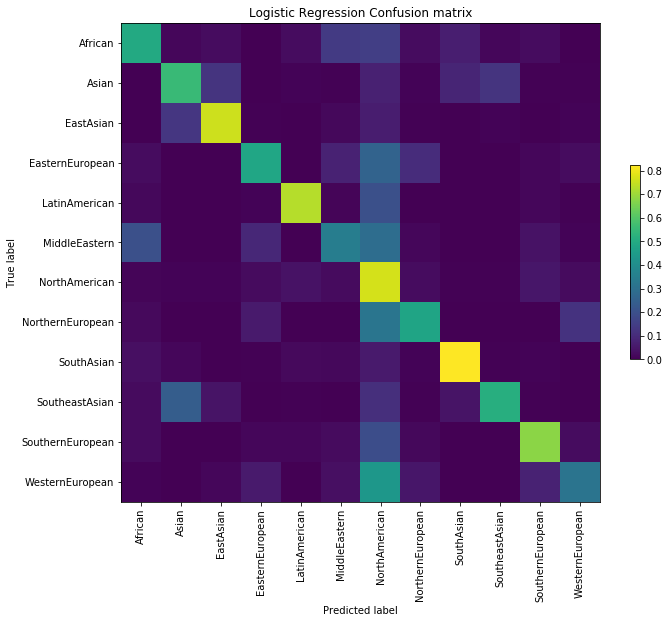

In [68]:
#parameters = {'C':[0.4,0.5,0.6,0.7],
#             'solver' : ('newton-cg', 'liblinear')}
parameters = {'C':[0.7],
              'solver' : ('liblinear',)}

logistic = LogisticRegression(class_weight="balanced",multi_class="auto",max_iter=150,warm_start=True)

trainEvalModel(logistic,"Logistic Regression",parameters)

# SVM

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=True)
Best f1_weighted score = 0.731578510305966
Best f1_weighted test score = 0.7226229530964672
Model accuracy 0.9739583333333334 for 2.284898250624777%% of recipes
Best accuracy 0.95 confidence test score = 0.9739583333333334
[0.6987980483160776, 0.5455378320326721, 0.7592929039978988, 0.6987980483160776, 0.7226229530964672]


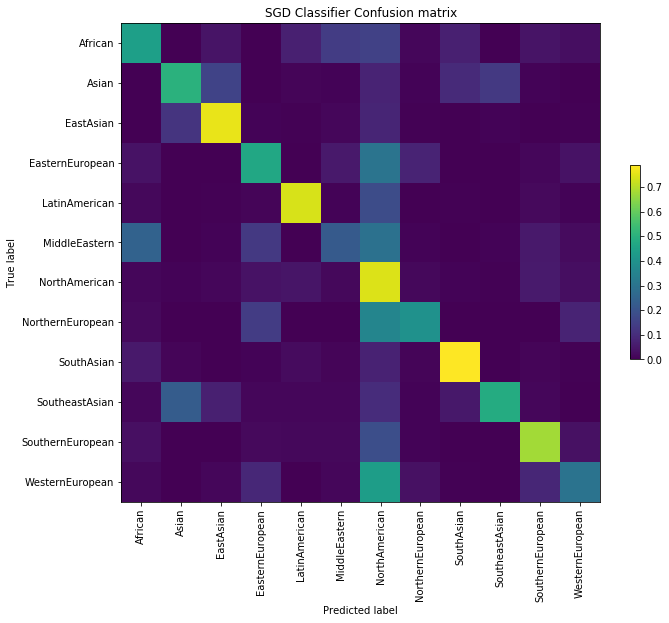

In [69]:
parameters = {'loss':("log",)}#('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron')}

sgd = SGDClassifier(class_weight="balanced",early_stopping=True,warm_start=True)

trainEvalModel(sgd,"SGD Classifier",parameters)

# Naive Bayes

ComplementNB(alpha=0.2, class_prior=None, fit_prior=True, norm=False)
Best f1_weighted score = 0.7120362499979326
Best f1_weighted test score = 0.7083263033294411
Model accuracy 0.903876582278481 for 30.084493633226227%% of recipes
Best accuracy 0.95 confidence test score = 0.903876582278481


C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7247411638700464, 0.3587485087876405, 0.7042848603885928, 0.7247411638700464, 0.7083263033294411]


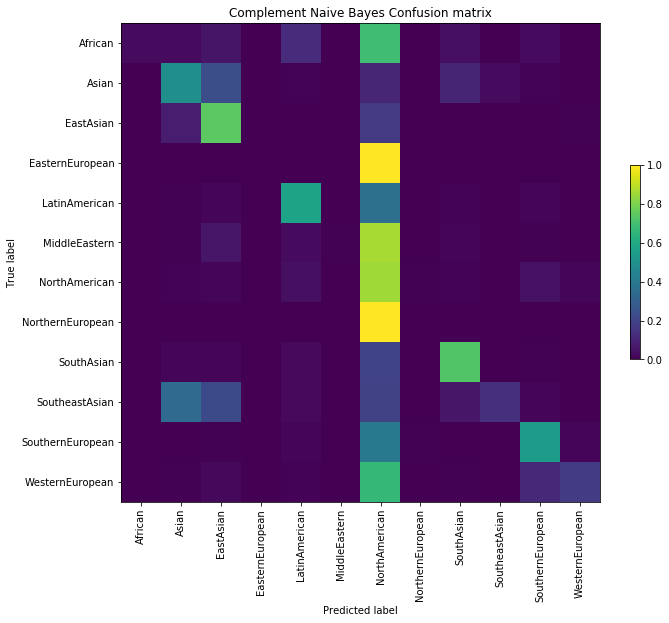

In [70]:
parameters = {'alpha':[0.2,]}#[i*0.2 for i in range(1,5)]}

trainEvalModel(ComplementNB(),"Complement Naive Bayes",parameters)

# Decision Tree 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')
Best f1_weighted score = 0.6839010649608573
Best f1_weighted test score = 0.684099271002215
Model accuracy 0.691033874826848 for 94.50196358443414%% of recipes
Best accuracy 0.95 confidence test score = 0.691033874826848
[0.6864810186838034, 0.37948152512695205, 0.6821657454057366, 0.6864810186838034, 0.684099271002215]


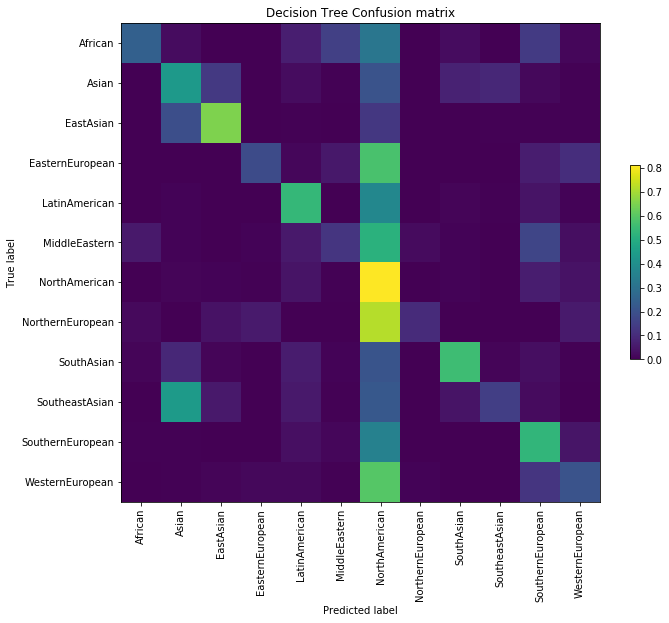

In [71]:
parameters = {"criterion":["gini",],#"entropy"],
            "splitter":["best","random"]}

trainEvalModel(DecisionTreeClassifier(),"Decision Tree",parameters)

# Extra Tree 

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Best f1_weighted score = 0.7332383409806227
Best f1_weighted test score = 0.7384105936589224
Model accuracy 0.860925572519084 for 24.94347256932048%% of recipes
Best accuracy 0.95 confidence test score = 0.860925572519084
[0.7679400214209211, 0.362378030018121, 0.7436608001712226, 0.7679400214209211, 0.7384105936589224]


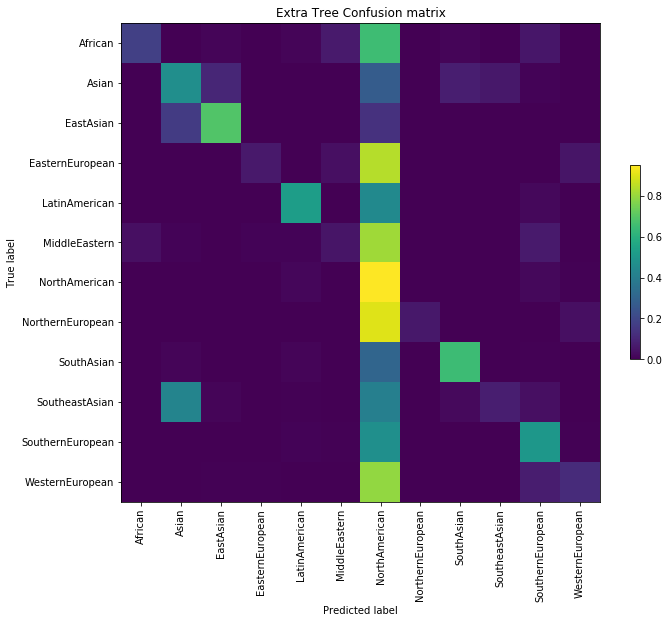

In [72]:
parameters = {"criterion":["gini",]}#"entropy"]}

trainEvalModel(ExtraTreesClassifier(),"Extra Tree",parameters)

## KNeighbors Classifier

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='distance')
Best f1_weighted score = 0.6331378357187872
Best f1_weighted test score = 0.6399011049208143
Model accuracy 0.8082685591979272 for 52.82042127811496%% of recipes
Best accuracy 0.95 confidence test score = 0.8082685591979272
[0.6746400095204094, 0.2823683579455832, 0.6340194325290951, 0.6746400095204094, 0.6399011049208143]


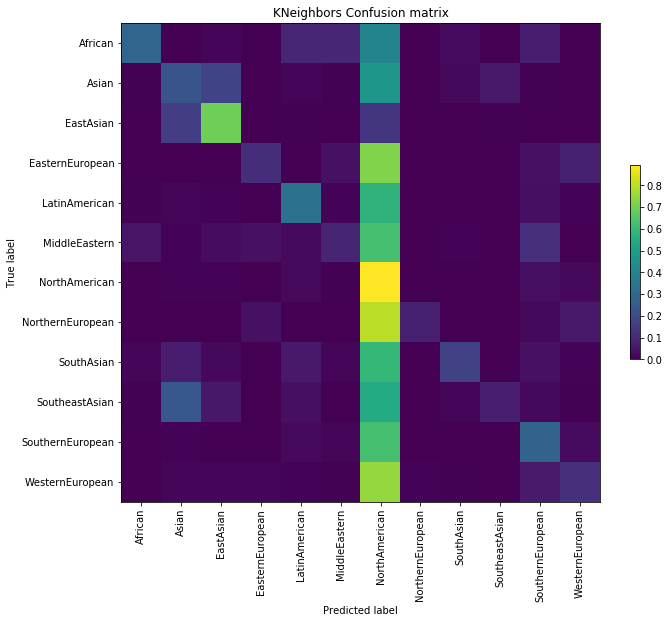

In [73]:
parameters = {"n_neighbors":[3,],#i for i in range(3,7)],
            "weights":["distance",]}#"uniform","distance"]}

trainEvalModel(KNeighborsClassifier(),"KNeighbors",parameters)

## Linear SVC

Best f1_weighted score = 0.851449652648647
Best f1_weighted test score = 0.7769249077710342
Model accuracy 0.9738933030646992 for 5.242175413542782%% of recipes
Best accuracy 0.95 confidence test score = 0.9738933030646992
[0.7769249077710342, 0.3734760158395312, 0.7622054960462157, 0.7769249077710342, 0.7495005961485559]


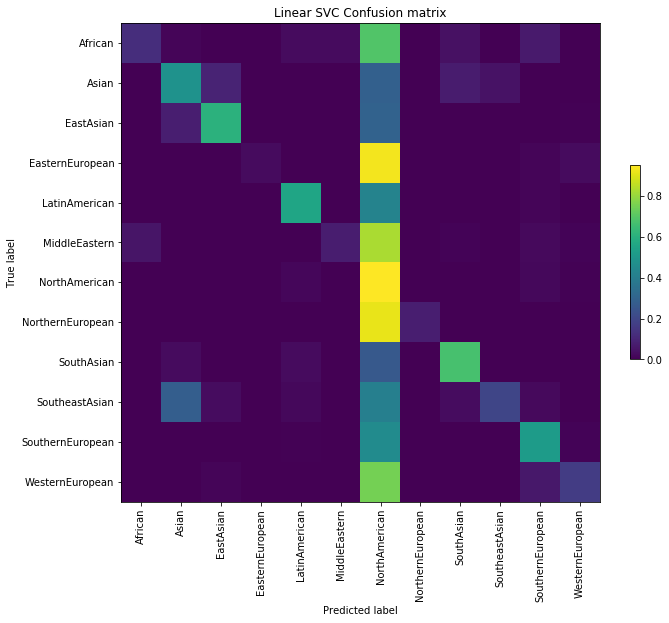

In [74]:
parameters = {"penalty":["l2",],#"l1"],
             "dual":[False,True],
             "C":[1]}#i for i in range(1,5)]}

trainEvalModel(LinearSVC(),"Linear SVC",parameters)

# Random Forest

much slower and a bit worse

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)
Best f1_weighted score = 0.7056839730226243
Best f1_weighted test score = 0.7103455810898355
Model accuracy 0.9628830384117393 for 13.786742829941687%% of recipes
Best accuracy 0.95 confidence test score = 0.9628830384117393
[0.7398548137569916, 0.34279615183242035, 0.71188206580118, 0.7398548137569916, 0.7103455810898355]


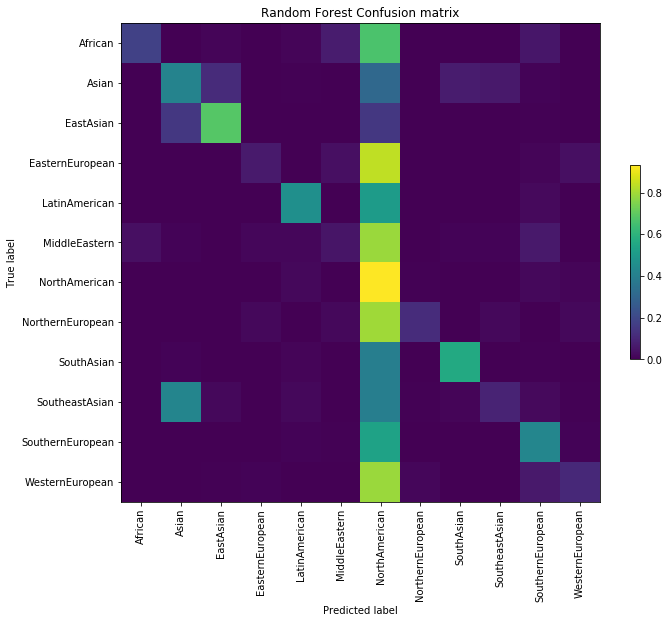

In [75]:
parameters = {'max_depth':(None,)}#3,5,8)}

rf = RandomForestClassifier(n_estimators=50, random_state=123,class_weight="balanced")

trainEvalModel(rf,"Random Forest",parameters)

# NN eval